# _Long Only Portfolio_

The following notebook will introduce you to a simple performance analyses of our long only strategy for a timeline of 105 months between 2011 and 2019. Our benchmark is the SPX and fees are applied annually. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from texttable import Texttable
from scipy.stats import kurtosis, skew
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import scipy
from scipy.stats import skewnorm

In [2]:
data= pd.read_csv("../data/long_only_return_.csv")
data['date'] = pd.to_datetime(data['date'])
data['sp500'] = data['sp500']/100
data['effectif'] = data['effectif']/100
data['prediction'] = data['prediction']/100
data.head()

,sp500,effectif,prediction,date
0,-0.001047,0.053932,0.036979,2011-03-01
1,0.028495,0.035936,0.033756,2011-04-01
2,-0.013501,0.004969,0.029150,2011-05-01
3,-0.018257,0.007212,0.030575,2011-06-01
4,-0.021474,-0.014186,0.038480,2011-07-01


### A). Quick statistics

In [3]:
t = Texttable()
t.add_rows([['Series', 'Mean Return', 'Std', 'Kurtosis', 'Skewness'], 
            ['SPX', str(round(data['sp500'].mean()*100,2))+'%', str(round(data['sp500'].std()*100,2))+'%',
             str(round(kurtosis(data['sp500']),2))+'%',  str(round(skew(data['sp500']),2))+'%'], 
            
            ['Portfolio', str(round(data['effectif'].mean()*100,2))+'%', str(round(data['effectif'].std()*100,2))+'%',
              str(round(kurtosis(data['effectif']),2))+'%',  str(round(skew(data['effectif']),2))+'%'
            ]])

print(t.draw())
ex_ret = (round((data['effectif'].mean()*100-data['sp500'].mean()*100),5)) 
print('The Excess Return of our Portfolio on average is: '+str(ex_ret)+'% compared to our benchmark')

+-----------+-------------+-------+----------+----------+
|  Series   | Mean Return |  Std  | Kurtosis | Skewness |
+===========+=============+=======+==========+==========+
| SPX       | 0.88%       | 3.38% | 0.87%    | -0.35%   |
+-----------+-------------+-------+----------+----------+
| Portfolio | 1.28%       | 2.8%  | -0.29%   | -0.14%   |
+-----------+-------------+-------+----------+----------+
The Excess Return of our Portfolio on average is: 0.4% compared to our benchmark



- The chart shows the difference in volatility of our two series, clearly the SPX is more volatile. 
- Correlation between our series: 49.7%


C:\Users\Wenceslas\Anaconda3\envs\cours\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


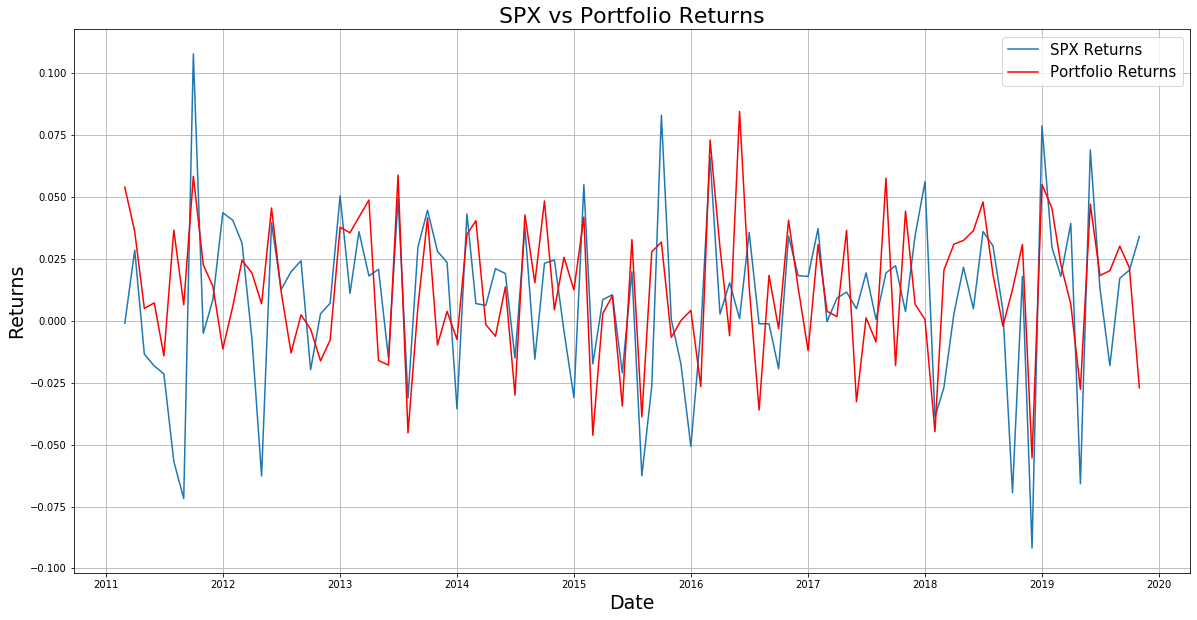

In [4]:
plt.figure(figsize=(20,10))
plt.plot(data.date, data.sp500, label='SPX Returns')
plt.plot(data.date, data.effectif, c='r', label='Portfolio Returns')

plt.title('SPX vs Portfolio Returns', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Returns', fontsize=19)
plt.legend(prop={'size': 15})
plt.grid()
print('\n- The chart shows the difference in volatility of our two series, clearly the SPX is more volatile.',
     '\n- Correlation between our series: '+str(round(data.corr().iloc[0,1],3)*100)+'%')
plt.show()


- The chart shows the difference in volatility of our two series, clearly the SPX is more volatile. 
- Correlation between our series: 49.7%


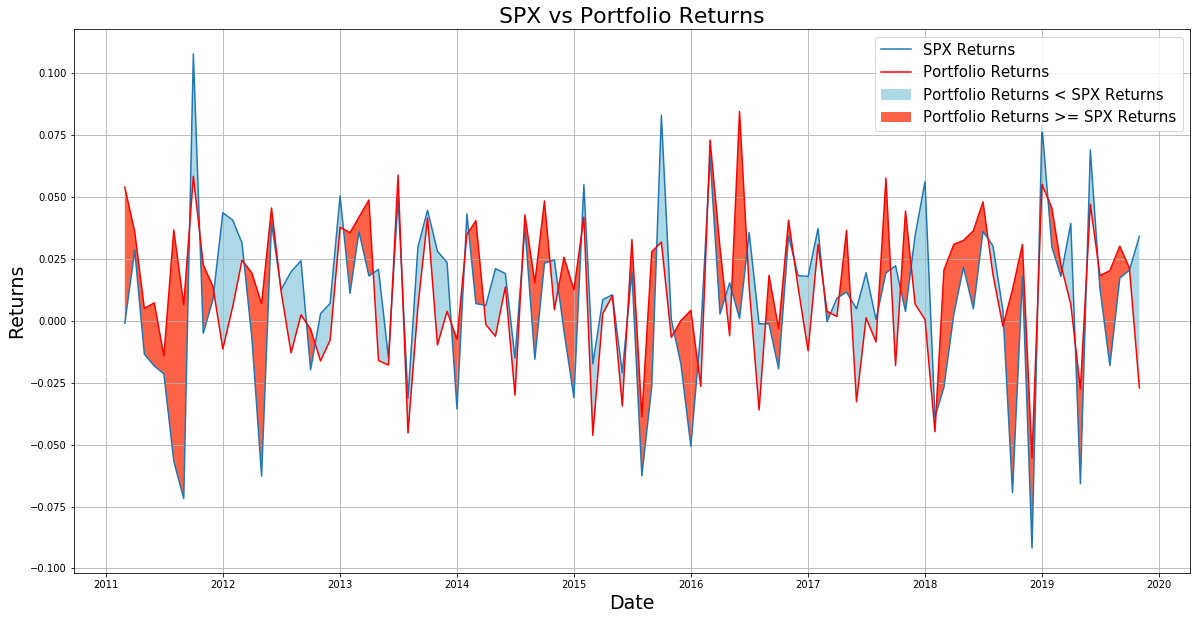

In [5]:
plt.figure(figsize=(20,10))
plt.plot(data.date, data.sp500, label='SPX Returns')
plt.plot(data.date, data.effectif, c='r', label='Portfolio Returns')

# If our portfolio return is above SP, then color the area between SP and portfolio return in tomato
# else fill with lightblue
plt.fill_between(data["date"], data["sp500"], data["effectif"]
                , where= data["sp500"] > data["effectif"]
                , facecolor= "lightblue"
                , interpolate= True
                , label= "Portfolio Returns < SPX Returns")
plt.fill_between(data["date"], data["sp500"], data["effectif"]
                , where= data["sp500"] <= data["effectif"]
                , facecolor= "tomato"
                , interpolate= True
                , label= "Portfolio Returns >= SPX Returns")


plt.title('SPX vs Portfolio Returns', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Returns', fontsize=19)
plt.legend(prop={'size': 15})
plt.grid()
print('\n- The chart shows the difference in volatility of our two series, clearly the SPX is more volatile.',
     '\n- Correlation between our series: '+str(round(data.corr().iloc[0,1],3)*100)+'%')
plt.show()

### B). Notes about normality distribution, random walk and extreme returns

In [6]:
# Normality distribution of our returns

def compare_hist_to_norm(data, bins= 25):
    fig= plt.figure(figsize= (10, 5))
    # mu, std, sk, k= scipy.stats.norm.stats(data, moments='mvsk')
    mu, std= scipy.stats.norm.fit(data)
    # params= scipy.stats.norm.fit(data)
    # sk= scipy.stats.skewnorm(data)
    # Plot l'hist
    plt.hist(data, bins= bins, density=True, alpha=0.6,
    color='purple', label= "Données")
    # Plot le PDF.
    
    xmin, xmax= plt.xlim()
    X= np.linspace(xmin, xmax)
    
    plt.plot(X, scipy.stats.norm.pdf(X, mu, std), label= "Normal Distribution")
    plt.plot(X, skewnorm.pdf(X, *skewnorm.fit(data)), color= 'black', label= "Skewed Normal Distribution")
    
    mu, std= scipy.stats.norm.fit(data)
    sk= scipy.stats.skew(data)
    
    title2= "Moments mu: {}, sig: {}, sk: {}".format(round(mu,4), round(std, 4), round(sk, 4))
    plt.ylabel("Frequency", rotation= 90)
    plt.title(title2)
    plt.legend()
    
    plt.show()

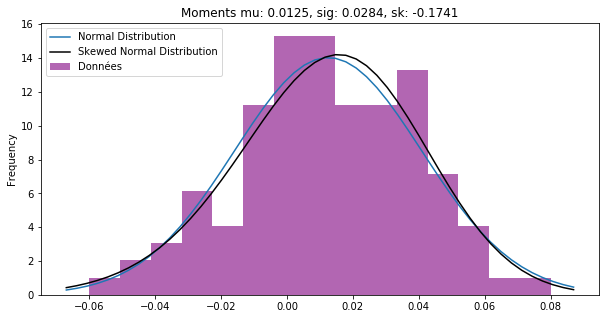

In [7]:
# Our portfolio returns
# warning, we rounded those returns to make the plot more aggragated
compare_hist_to_norm([round(val, 2) for val in data["effectif"].values], bins= 15)

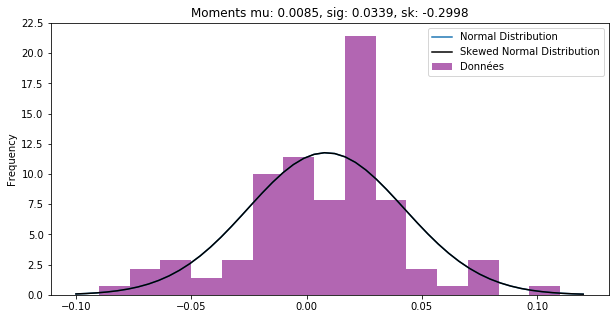

In [8]:
# SPX distribution
# warning, we rounded those returns to make the plot more aggragated
compare_hist_to_norm([round(val, 2) for val in data["sp500"].values], bins= 15)

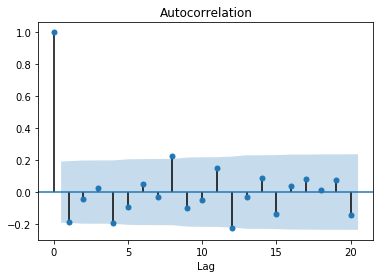

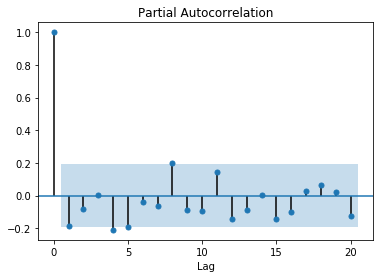

In [9]:
# Autocorrelation for all periods (with confidence intervals)
plot_acf(data["effectif"], lags= 20)
plt.xlabel("Lag")
# partial autocorr
plot_pacf(data["effectif"], lags= 20)
plt.xlabel("Lag")

plt.show()

_Our Portfolio on average outperforms the benchmark with a lower standard deviation (fees not included)._
    
_By the rule of thumb if the skewness is between -0.5 and 0.5, the data are fairly symmetrical ; if the skewness is between -1 and -0.5(negatively skewed) or between 0.5 and 1(positively skewed), the data are moderately skewed ; if the skewness is less than -1(negatively skewed) or greater than 1(positively skewed), the data are highly skewed. SPX is positively skewed, but our portfolio is sim-neg skewed, the reason why we beat our benchmark._

_Kurtosis is a statistical measure that defines how heavily the tails of a distribution differ from the tails of a normal distribution. In other words, kurtosis identifies whether the tails of a given distribution contain extreme values. A large kurtosis is associated with a high level of risk of an investment because it indicates that there are high probabilities of extremely large and extremely small returns. On the other hand, a small kurtosis signals a moderate level of risk because the probabilities of extreme returns are relatively low. 
Note: Scipy Kurtosis is calculated using the the Fisher methods which compares our Kurtosis with the normal one. So the result is calculated using Kurt - 3. Our portfolio has less extreme events compared to the normal one and the SPX has more extreme ones._
    
_All the results will be better shown below._

COMMENTAIRES

### C). Rolling metrics

In [10]:
# Rolling metrics
window= 36
lag= 1 # for autocorrelation

effectif_rolling_mean= data["effectif"].rolling(window).mean()
effectif_rolling_mean.index= data["date"]
effectif_rolling_std= data["effectif"].rolling(window).std()
effectif_rolling_std.index= data["date"]
effectif_rolling_autocorr= data["effectif"].rolling(window).apply(
    lambda row: pd.Series(row).autocorr(lag))
effectif_rolling_autocorr.index= data["date"]


sp_rolling_mean= data["sp500"].rolling(window).mean()
sp_rolling_mean.index= data["date"]
sp_rolling_std= data["sp500"].rolling(window).std()
sp_rolling_std.index= data["date"]
sp_rolling_autocorr= data["sp500"].rolling(window).apply(
    lambda row: pd.Series(row).autocorr(lag))
sp_rolling_autocorr.index= data["date"]

C:\Users\Wenceslas\Anaconda3\envs\cours\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Wenceslas\Anaconda3\envs\cours\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


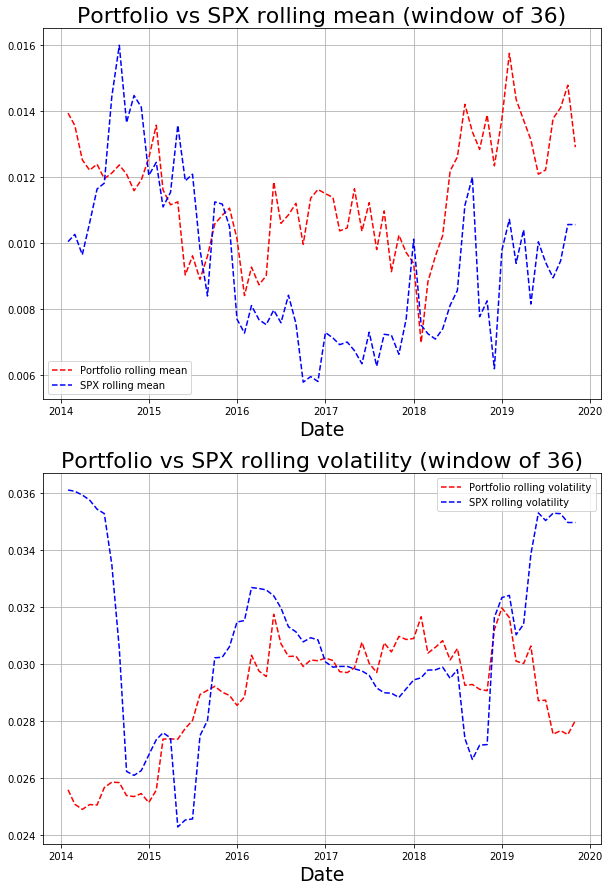

In [11]:
# PLot rolling metrics

# fig= plt.figure(figsize= (20, 30))
ligne= 2
fig, ax= plt.subplots(ligne, 1, figsize= (10, 15))

legend_dico= {0: "mean", 1: "volatility"}
def return_title(i, dic= legend_dico, window= window):
    return "Portfolio vs SPX rolling {} (window of {})".format(dic[i], window)

# Rolling mean
mean= return_title(0)
ax[0].plot(effectif_rolling_mean, linestyle= "--", color= "red"
         , label= "Portfolio rolling {}".format(legend_dico[0]))
ax[0].plot(sp_rolling_mean, linestyle= "--", color= "blue"
         , label= "SPX rolling {}".format(legend_dico[0]))
ax[0].set_title(mean, size= 22)

# Rolling std
std= return_title(1)
ax[1].plot(effectif_rolling_std, linestyle= "--", color= "red"
         , label= "Portfolio rolling {}".format(legend_dico[1]))
ax[1].plot(sp_rolling_std, linestyle= "--", color= "blue"
         , label= "SPX rolling {}".format(legend_dico[1]))
ax[1].set_title(std, size= 22)

# Rolling autocorr ????



for i in range(ligne):
    ax[i].set_xlabel("Date", fontsize= 19)
    ax[i].grid()
    ax[i].legend()

plt.show()

COMMENTAIRES

### D). Portfolio evaluation

#### 1).

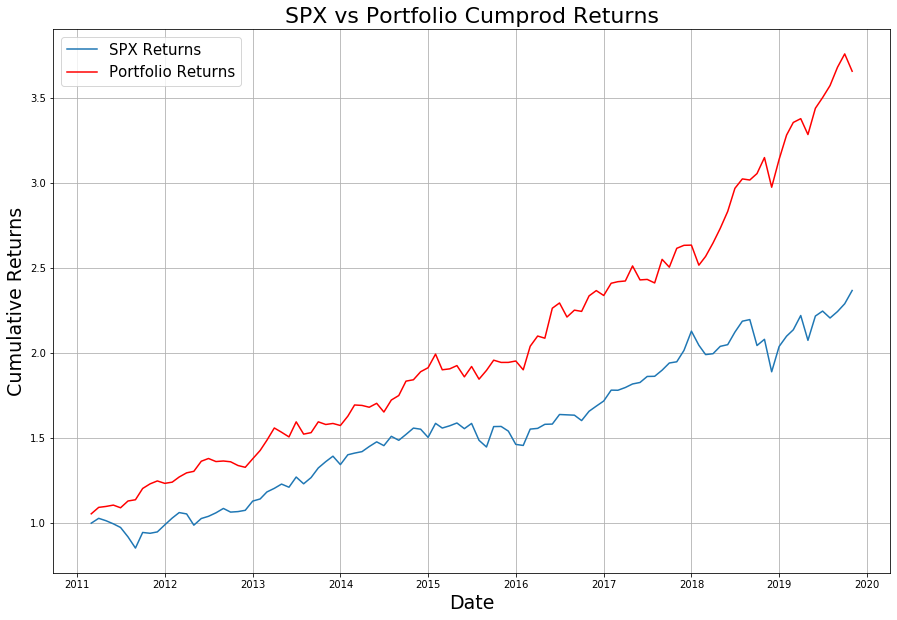

In [12]:
plt.figure(figsize=(15,10))
plt.plot(data.date,(1+data['sp500']).cumprod(),label='SPX Returns')
plt.plot(data.date,(1+data['effectif']).cumprod(), c='r', label='Portfolio Returns')
plt.title('SPX vs Portfolio Cumprod Returns', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Cumulative Returns', fontsize=19)
plt.legend(prop={'size': 15})
plt.grid()
plt.show()

In [13]:
#################### FEES #######################################
df = data.copy()

fees = (1.01)**(1/12) - 1

df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['withfees'] = df['effectif'] - fees

# We create a two lists to iterate for creating slices of dataframe 

a = [0] + (list(df[df['month'] == 12].index)) 
b =  (list(df[df['month'] == 12].index)) + [104]

# The length of the two should match

len(a) == len(b)

True

In [14]:
# List that will keep the final values
portfolio_final = []

for l1,l2 in zip(a,b):
    
    # This "if" catches the year that we had only 10 months
    if l2 - l1 < 11:
        
        # Bonus 
        bonus = (1.2)**(1/(l2-l1+1)) - 1
        
        # It slices the dataframes and it takes the the cumprud of those current slices
        slice_df =  df.iloc[ l1: l2+1]
        spxcpr = (1 + slice_df['sp500'].values).cumprod()
        pptcpr = (1 + slice_df['withfees'].values).cumprod()
        if pptcpr[-1] > spxcpr[-1]:
            
            pptcpr = pptcpr - bonus
        
        else:
            
            print('Sorry, next time bro')
        
        # This part will reverse the cumprod : explanation en bas grooooooooos
        fist = pptcpr[0] - 1
        pptcpr = pptcpr[::-1]
        pptcpr = np.divide(pptcpr[:-1],pptcpr[1:]) - 1
        pptcpr = pptcpr[::-1]
        pptcpr = [fist] + list(pptcpr)

        portfolio_final.append(pptcpr)     
        
    # This "if" catches the years that are full 12 months
    elif l2 - l1 == 12:

        bonus = (1.2)**(1/12) - 1
        
        slice_df = df.iloc[ l1+1: l2+1] 
        spxcpr = (1 + slice_df['sp500'].values).cumprod()
        pptcpr = (1 + slice_df['withfees'].values).cumprod()

        if pptcpr[-1] > spxcpr[-1]:
            pptcpr = pptcpr - bonus
        else:
            print('Sorry, next time bro')
            
        fist = pptcpr[0] - 1
        pptcpr = pptcpr[::-1]
        pptcpr = np.divide(pptcpr[:-1],pptcpr[1:]) - 1
        pptcpr = pptcpr[::-1]
        pptcpr = [fist] + list(pptcpr)
        
        portfolio_final.append(pptcpr)   
        
    # This "if" catches the years that we had 11 months
    elif l2 - l1 == 11 : 

        bonus = (1.2)**(1/(l2-l1)) - 1
        slice_df = df.iloc[ l1+1: l2+1] 
        spxcpr = (1 + slice_df['sp500'].values).cumprod()
        pptcpr = (1 + slice_df['withfees'].values).cumprod()

        if pptcpr[-1] > spxcpr[-1]:
            pptcpr = pptcpr - bonus
        else:
            print('Sorry, next time bro')
        
        fist = pptcpr[0] - 1
        pptcpr = pptcpr[::-1]
        pptcpr = np.divide(pptcpr[:-1],pptcpr[1:]) - 1
        pptcpr = pptcpr[::-1]
        pptcpr = [fist] + list(pptcpr)
        portfolio_final.append(pptcpr)  

df['final_ppt'] = np.concatenate(portfolio_final, axis=0)

data2= df.copy()
data2.head()

Sorry, next time bro
Sorry, next time bro
Sorry, next time bro
Sorry, next time bro


,sp500,effectif,prediction,date,month,withfees,final_ppt
0,-0.001047,0.053932,0.036979,2011-03-01,3,0.053102,0.034703
1,0.028495,0.035936,0.033756,2011-04-01,4,0.035107,0.035731
2,-0.013501,0.004969,0.029150,2011-05-01,5,0.004139,0.004210
3,-0.018257,0.007212,0.030575,2011-06-01,6,0.006383,0.006492
4,-0.021474,-0.014186,0.038480,2011-07-01,7,-0.015016,-0.015271


In [15]:
t = Texttable()
t.add_rows([['Series', 'Total Return'], 
            ['SPX', str(round(list((1+data['sp500']).cumprod())[-1]-1,3)*100)+'%'] ,
            
            ['Portfolio (without fees)',  str(round(list((1+data['effectif']).cumprod())[-1]-1,3)*100)+'%'
            ],
            
            ['Portfolio (with fees)',  str(round(list((1+data2['final_ppt']).cumprod())[-1]-1,3)*100)+'%'
            ]
           ])
print(' Results in Cumulative Return (without fees)')
print(t.draw())

 Results in Cumulative Return (without fees)
+--------------------------+--------------+
|          Series          | Total Return |
+==========================+==============+
| SPX                      | 136.7%       |
+--------------------------+--------------+
| Portfolio (without fees) | 265.5%       |
+--------------------------+--------------+
| Portfolio (with fees)    | 212.8%       |
+--------------------------+--------------+


In [16]:
def alpha_beta(x,y,verbose = True):
    
    import statsmodels.api as sm
    from statsmodels import regression
    
#     x = x.values
#     y = y.values
    
    # Adding constant
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    
    alpha, beta = model.params[0], model.params[1]
    if verbose == True:
        t = Texttable()
        t.add_rows([['Series', 'Alpha' , 'Beta'], 
            ['SPX', str(round(alpha,2))+' %',str(round(beta,2))+' %']])
        print(t.draw())
    else:
        return alpha, beta
    
print('The results are shown for the entire period (wihtout fees)')
alpha_beta(data["sp500"].values, data["effectif"].values)

# on recalcul les beta / alpha avec les ct !
# en global
print('\nThe results are shown for the entire period (with fees)')
alpha_beta(data2["sp500"].values, data2["final_ppt"].values)

The results are shown for the entire period (wihtout fees)
+--------+--------+--------+
| Series | Alpha  |  Beta  |
+========+========+========+
| SPX    | 0.01 % | 0.41 % |
+--------+--------+--------+

The results are shown for the entire period (with fees)
+--------+--------+--------+
| Series | Alpha  |  Beta  |
+========+========+========+
| SPX    | 0.01 % | 0.43 % |
+--------+--------+--------+


COMMENTAIRES

#### 2).

In [17]:
# This function will create windows 
def windows(iterable, n, m=1):
    length = len(iterable)
    i = 0

    while i + n < length:
        yield list(iterable[i:i + n+1])
        i += m

In [18]:
roll_alpha = []
roll_beta = []
n = 36

for be, al in zip((windows(data["sp500"], 36, 1)),(windows(data["effectif"], 36, 1))):
    alph,be = alpha_beta(be, al,False)
    roll_alpha.append(alph)
    roll_beta.append(be)

roll_alpha_before= roll_alpha
roll_beta_before= roll_beta

roll_alpha = []
roll_beta = []

for be, al in zip((windows(data2["sp500"], 36, 1)),(windows(data2["final_ppt"], 36, 1))):
    alph,be = alpha_beta(be, al,False)
    roll_alpha.append(alph)
    roll_beta.append(be)


- The chart shows the rolling Alpha with a window of 36


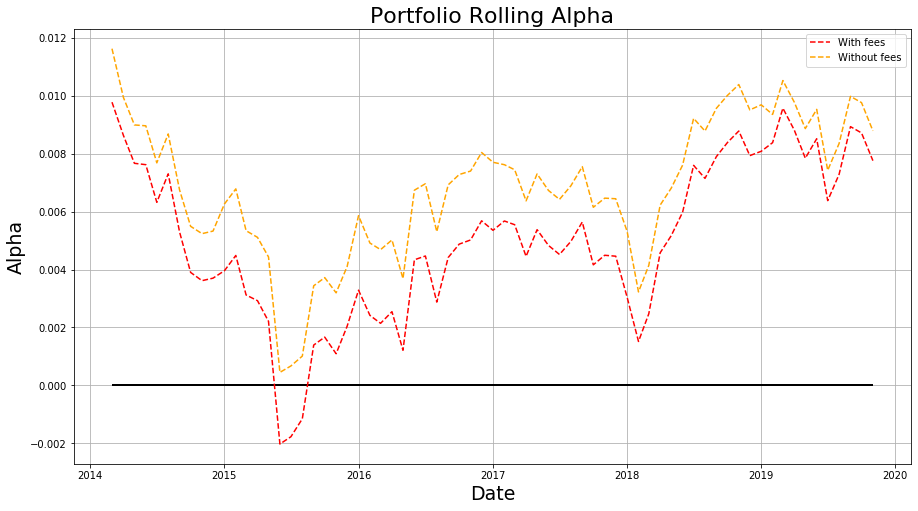

In [19]:
plt.figure(figsize=(15,8))
plt.plot(data2.date.values[-len(roll_alpha):]
         , roll_alpha, label="With fees"
         , color= "red", linestyle= "--")

plt.plot(data2.date.values[-len(roll_alpha_before):]
         , roll_alpha_before, label='Without fees'
         , color= "orange", linestyle= "--")

plt.hlines(np.repeat(0, len(roll_alpha))
           , xmin= data2.date.values[-len(roll_alpha_before):][0]
           , xmax= data2.date.values[-len(roll_alpha_before):][-1]
           , color= "black"
          )

plt.title('Portfolio Rolling Alpha', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Alpha', fontsize=19)
plt.grid()
plt.legend()
print('\n- The chart shows the rolling Alpha with a window of 36')
plt.show()


- The chart shows the rolling Beta with a window of 36


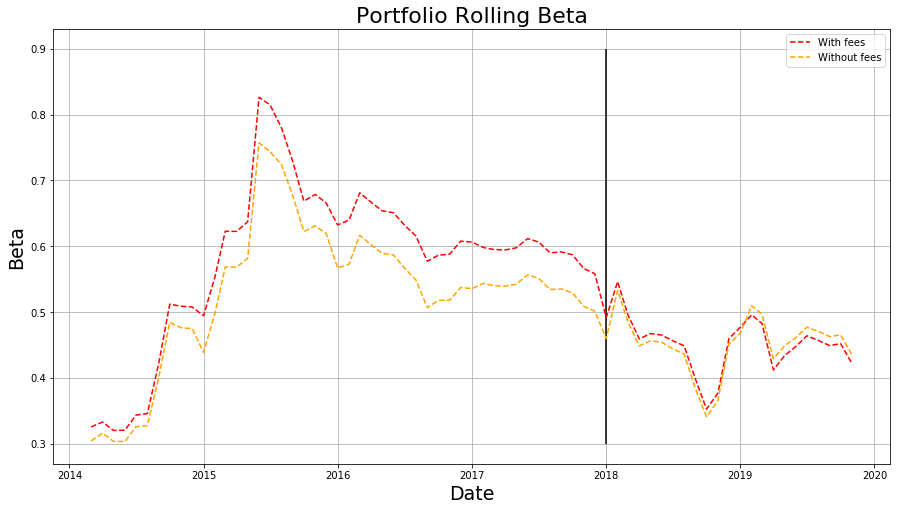

In [20]:
plt.figure(figsize=(15,8))
plt.plot(data2.date.values[-len(roll_beta):]
         , roll_beta, label='With fees', color= "red", linestyle= "--")

plt.plot(data2.date.values[-len(roll_beta_before):]
         , roll_beta_before, label='Without fees', color= "orange", linestyle= "--")

plt.vlines(ymin= 0.3, ymax= 0.9, x= "2018")

plt.title('Portfolio Rolling Beta', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Beta', fontsize=19)
plt.grid()
plt.legend()
print('\n- The chart shows the rolling Beta with a window of 36')
plt.show()

COMMENTAIRES

#### 3).

COMMENTAIRES

# La preuve est ici

In [21]:
np.random.seed([3,1415])
tidx = pd.date_range('2012-04-01', periods=10)
df = pd.DataFrame(dict(A=np.random.rand(10) / 10), tidx)
df

,A
2012-04-01,0.044494
2012-04-02,0.040755
2012-04-03,0.046015
2012-04-04,0.046524
2012-04-05,0.046269
2012-04-06,0.001655
2012-04-07,0.085045
2012-04-08,0.081774
2012-04-09,0.077796
2012-04-10,0.075798


In [22]:
pptcpr

[0.05422200218552553,
 0.044644516590982564,
 0.021868870685702202,
 0.005816263007898614,
 -0.028495336498215007,
 0.046216882829325456,
 0.017432996723495853,
 0.019374735878419536,
 0.029290160911462415,
 0.020498363724283486,
 -0.027925404305221502]

In [23]:
pptcpr = df.add(1)['A'].values.cumprod()
fist = pptcpr[0] - 1
pptcpr = pptcpr[::-1]
pptcpr = np.divide(pptcpr[:-1],pptcpr[1:]) - 1
pptcpr = pptcpr[::-1]
pptcpr = [fist] + list(pptcpr)
pptcpr

[0.04449393091533116,
 0.040755441542803306,
 0.04601484989404803,
 0.04652388411884356,
 0.04626910178634902,
 0.0016545445846420925,
 0.08504453670360923,
 0.0817744265099698,
 0.07779618448746062,
 0.07579833020430127]

In [24]:
dcum = df.add(1)['A'].values.cumprod()
reversed_arr = dcum[::-1]
reversed_arr2 = np.divide(reversed_arr[:-1],reversed_arr[1:]) - 1
reversed_arr2 = reversed_arr2[::-1]
reversed_arr3 = list(reversed_arr2)
reversed_arr3 = [reversed_arr[-1] -1] + reversed_arr3
reversed_arr3 

[0.04449393091533116,
 0.040755441542803306,
 0.04601484989404803,
 0.04652388411884356,
 0.04626910178634902,
 0.0016545445846420925,
 0.08504453670360923,
 0.0817744265099698,
 0.07779618448746062,
 0.07579833020430127]

In [25]:
reversed_arr3 == pptcpr

True

In [26]:
reversed_arr3 - df.A.values

array([ 9.02056208e-17,  7.63278329e-17, -9.71445147e-17, -9.71445147e-17,
       -6.93889390e-17,  6.65700134e-17, -1.38777878e-17,  8.32667268e-17,
        5.55111512e-17, -2.77555756e-17])